<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Super-Resolution" data-toc-modified-id="Super-Resolution-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Super Resolution</a></span><ul class="toc-item"><li><span><a href="#VGG16" data-toc-modified-id="VGG16-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>VGG16</a></span><ul class="toc-item"><li><span><a href="#ResSequential" data-toc-modified-id="ResSequential-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>ResSequential</a></span></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Scaling</a></span></li></ul></li><li><span><a href="#Upsampling" data-toc-modified-id="Upsampling-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Upsampling</a></span></li><li><span><a href="#Transposed-Convolutions" data-toc-modified-id="Transposed-Convolutions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Transposed Convolutions</a></span></li><li><span><a href="#Pixel-Shuffling" data-toc-modified-id="Pixel-Shuffling-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Pixel Shuffling</a></span></li><li><span><a href="#Checkerboard-pattern" data-toc-modified-id="Checkerboard-pattern-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Checkerboard pattern</a></span><ul class="toc-item"><li><span><a href="#Pixel-loss" data-toc-modified-id="Pixel-loss-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Pixel loss</a></span></li></ul></li><li><span><a href="#Progressive-resizing" data-toc-modified-id="Progressive-resizing-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Progressive resizing</a></span></li></ul></li><li><span><a href="#Segmentation" data-toc-modified-id="Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Segmentation</a></span></li><li><span><a href="#U-net" data-toc-modified-id="U-net-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>U-net</a></span></li></ul></div>

# Super Resolution
Earlier we looked at doing style transfer by directly optimizing pixels. 
Key idea: Optimizing the input directly and using activations as part of a loss function.

[3:55](https://youtu.be/nG3tT31nPmQ?t=3m55s). 
In Super-resolution we take a low resolution image (eg 72x72) and upscale it to a larger image (288x288) 
that looks as real as possible. 
Difficult, because at 72x72, there’s not much info on details. 
We will do it in a way that is independent of input size so we can use the model and apply it 
to a larger image (eg 288x288) and get something that’s 4 times bigger on each side (16 times bigger).
It works better at that level because there are finer details,
and we can really print out a high resolution print of something which earlier on was pretty pixelated.

It is kind of CSI style enhancement, we take something that appears like the information is not there,
and we invent it.
But the conv net is going to learn to invent it in a way that’s consistent with the information that is there, 
so hopefully it’s inventing the right information. 
We can create our own big dataset, without any labeling requirements,
because we can create a low-res image from a high-res image just by down sampling our images. 

TODO: invent “labels” (your dependent variables). For example:
- Deskewing: recognize things that have been rotated by 90 or 5 degrees and straighten them.
- Colorization: Make a bunch of images into black-and-white and learn to put the color back again.
- Noise-reduction: Do a really low quality JPEG save, and learn to put it back to how it should have been.
- higher palette: take something in a 16 color palette and put it back to a higher color palette.

Above can be used with pictures taken back on old digital cameras (before high-resolution),
or scanned old photos that are faded, etc. 


## VGG16
A couple of things which are interesting about VGG that make it still useful today [11:59]. 
The first one is that there’s more interesting layers going on here.
Most modern networks, including the ResNet family, the very first layer generally is a 7x7 conv with stride 2 or something similar. 
Which means we throw away half the grid size straight away.
So there is little opportunity to use the fine detail because we never do any computation with it. 
So that’s a problem for segmentation or super-resolution models because the fine details matters. 
We actually want to restore it. 

A 2nd problem is that the adaptive pooling layer entirely throws away the geometry in the last few sections.
This means the rest of the model doesn’t have as much interesting kind of learning.
For things which are dependent on position, any kind of localization based approach to anything that requires generative model is going to be less effective. 

Probably none of the existing architectures are actually ideal, so we may want to invent a new one,
say, take the VGG head and attach it to a ResNet backbone. 
Or, in ResNet, replace the (7x7 conv stride 2) with something more like an Inception stem.
With some tweaks to these architectures we can build more versatile models. 
Many architectures just do one thing, probably throwing away good stuff, given the focus on 
state of the art of something vs good at many things.

Thus, we use VGG even though it’s old and missing lots of good stuff [14:42]. 
We use a more modern version of VGG where batchnorm is added after all the convolutions. 
We use VGG16, because VGG19 is bigger and heavier, and not better. 

`FilesDataset` from fastai.dataset.
module and seeing what’s there [15:45]. Because just about anything you’d want, we probably have something that’s almost what you want. So in this case, I want a dataset where my x’s are images and my y’s are also images. There’s already a files dataset we can inherit from where the x’s are images and then I just inherit from that and I just copied and pasted the get_x and turn that into get_y so it just opens an image. Now I’ve got something where the x is an image and the y is an image, and in both cases, what we’re passing in is an array of files names.

A couple of interesting things here [27:10]. 

### ResSequential
One is that this idea of having some kind of a main ResNet path (conv, ReLU, conv) and then turning that into a ReLU block by adding it back to the identity.
— it’s something we do so often that I factored it out into a tiny little module called `ResSequential.` 
It simply takes a bunch of layers that you want to put into your residual path, turns that into a sequential model, runs it, and then adds it back to the input. 
With this little module, we can now turn anything, like conv activation conv, 
into a ResNet block just by wrapping in `ResSequential.`

### Scaling
Normally a Res block just has `x + self.m(x)` in its forward. 
But we also got `* self.res_scale`. 
Here `res_scale` is the number $0.1$. 
The inventor of batchnorm recently trained ImageNet in under an hour,
with many machines in parallel to create large batch sizes. 
When we increase the batch size by order N, we also increase the learning rate by order N to go with it. 
So a very large batch size training means very high learning rate. 
With large batch sizes (8K, or even 32K) at the start of training, activations would explode.
But, in the ResNet blocks, if he multiplied them by some number smaller than 1, eg .1 or .2, 
it really helped stabilize training at the start. 
The problem of weights going to infinity is about the discrete and finite nature of computers.
So often little tricks can make the difference.<br>
We are just toning things down based on our initial initialization. 

There are other ways to do this. 
Nvidia's **LARS** uses discriminative learning rates calculated in real time. 
Basically looking at the ratio between the gradients and the activations to scale learning rates by layer. 
So they found that they didn’t need this trick to scale up the batch sizes a lot. 
Maybe a different initialization would be all that’s necessary. 
This is important to train models quickly, using high learning rates and ideally getting super convergence. 



## Upsampling
upsampling is a bit interesting because it is not doing either of two things (transposed or fractionally strided convolutions or nearest neighbor upsampling followed by a 1x1 conv). So let’s talk a bit about upsampling.
Below picture from the paper [Perceptual Losses for Real-Time Style Transfer and Super Resolution](https://arxiv.org/abs/1603.08155). 
Notice its got artifacts in it, everywhere.
One of the reason for this is that they use transposed convolutions,
and we know not to use transposed convolutions.

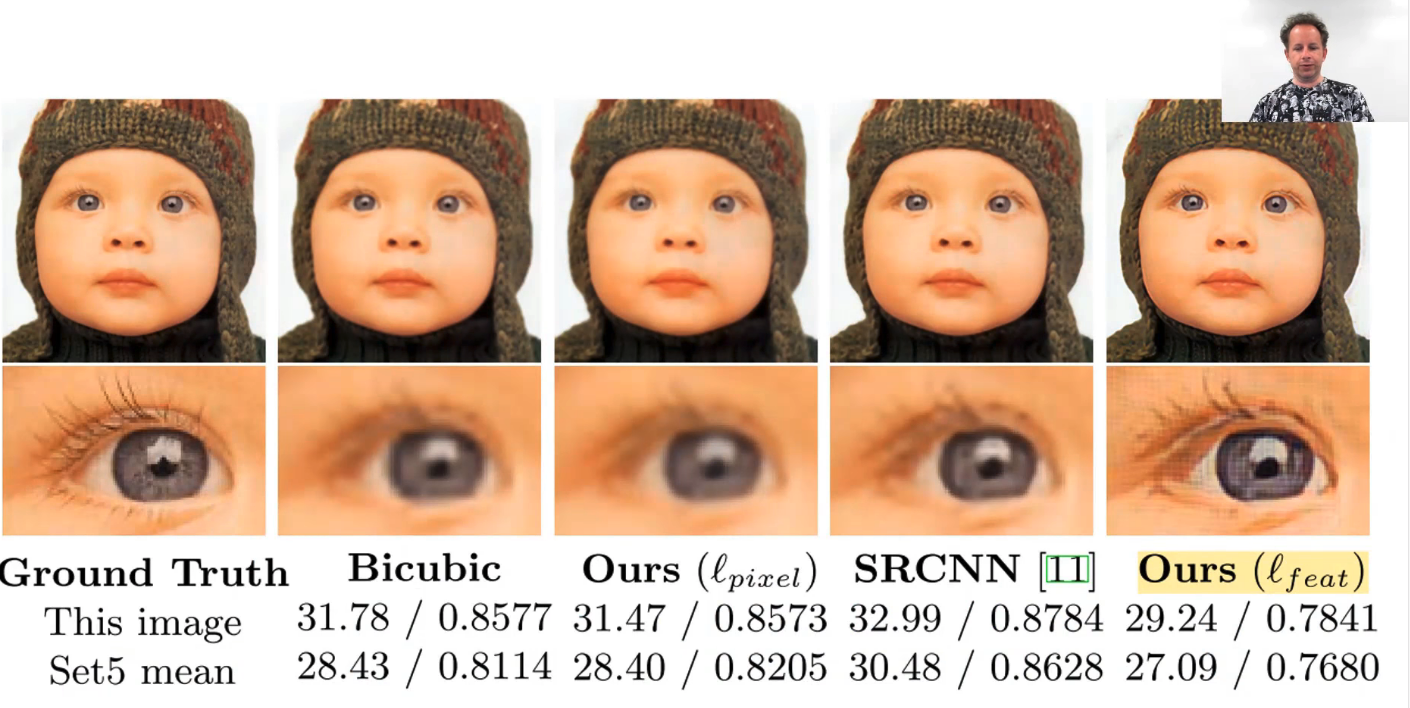

## Transposed Convolutions
Here are transposed convolutions [35:39], from the convolutional arithmetic paper.
If we are going from (blue is the original image) 3x3 image up to a 5x5 image (6x6 if we added a layer of padding), then all a transpose convolution does is it uses a regular 3x3 conv but it sticks white zero pixels between every pair of pixels. That makes the input image bigger and when we run this convolution over it, therefore gives us a larger output. But that’s obviously stupid because when we get here, for example, of the nine pixels coming in, eight of them are zero. So we are just wasting a whole a lot of computation. On the other hand, if we are slightly off then four of our nine are non-zero. But yet, we only have one filter/kernel to use so it can’t change depending on how many zeros are coming in. So it has to be suitable for both and it’s just not possible so we end up with these artifacts.
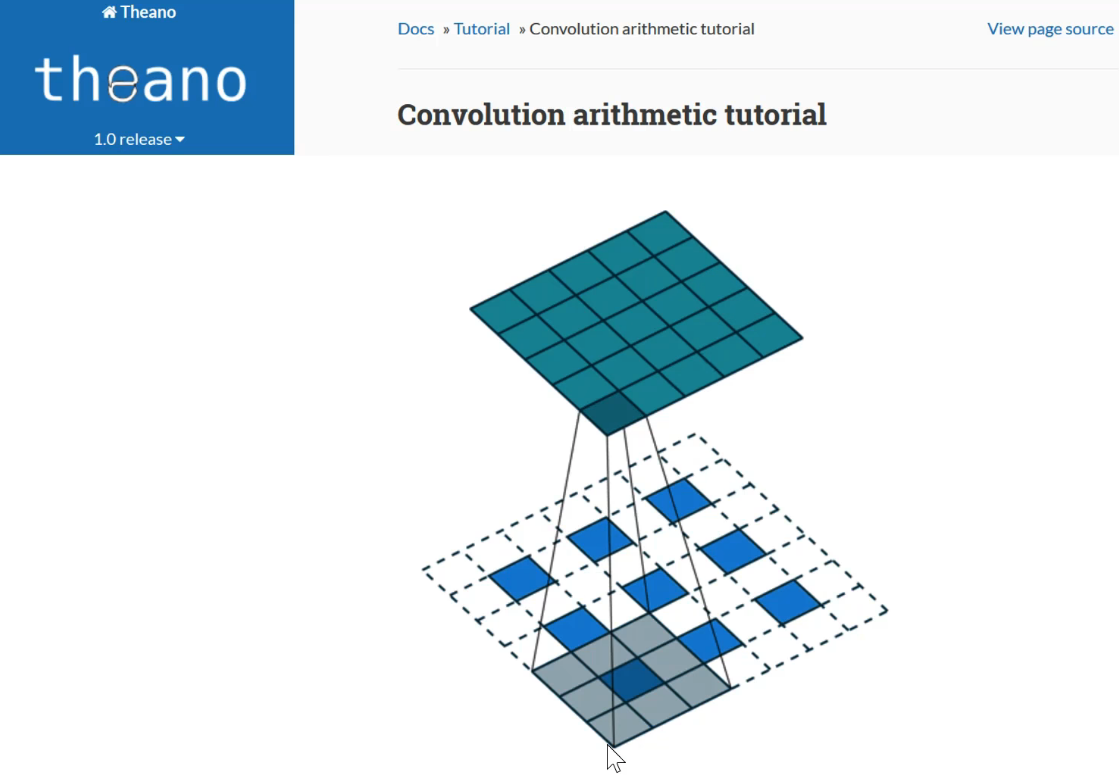

One approach we’ve learnt to make it a bit better is to not put white things here but instead to copy the pixel’s value to each of these three locations [36:53]. So that’s a nearest neighbor upsampling. That’s certainly a bit better, but it’s still pretty crappy because now when we get to these nine (as shown above), 4 of them are exactly the same number. And when we move across one, then now we’ve got a different situation entirely. So depending on where we are, in particular, if we are here, there’s going to be a lot less repetition:
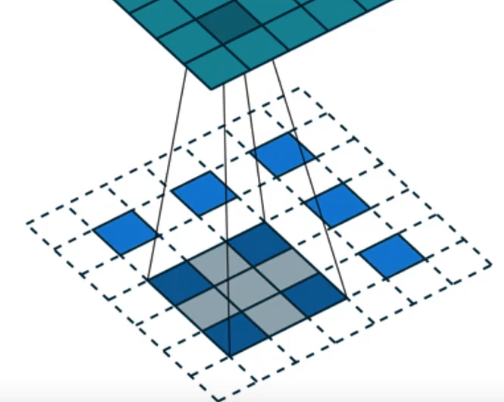
So again, we have this problem where there’s wasted computation and too much structure in the data, and it’s going to lead to artifacts again. So upsampling is better than transposed convolutions — it’s better to copy them rather than replace them with zero. But it’s still not quite good enough.

## Pixel Shuffling
So instead, we are going to do the pixel shuffle [37:56]. 
Pixel shuffle is an operation in this sub-pixel convolutional neural network,
a little bit mind-bending but fascinating.
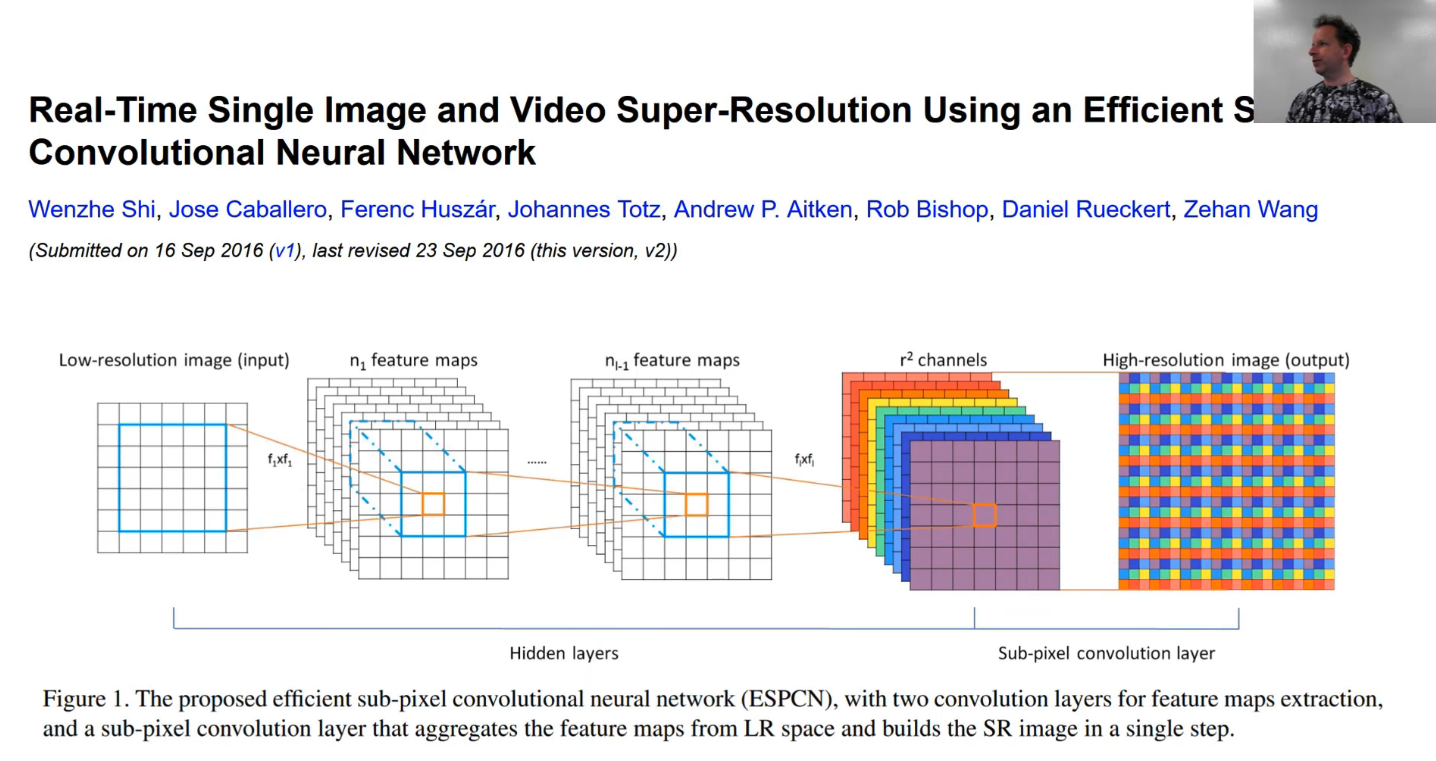

We start with the input, go through some convolutions to create some feature maps for a while,
until eventually we get to a layer that has $n_{l-1} feature maps. 
We do another 3x3 conv, and our goal is to go from a 7x7 grid cell 
(we’re going to do a 3x3 upscaling) up to a 21x21 grid cell. 
What is another way we could do that? 
To make it simpler, let’s just pick one face, we  
take the top-most filter and do a convolution over that just to see what happens. 
We use a convolution where the kernel size (ie  the number of filters) is 9 times bigger than we need. 
So if we needed 64 filters, we do 64x9 filters. 
Why? Here, $r=3$ is the the scale factor so 3² is 9.
The 9 filters are shown in different colors in the figure.
We started with 7x7, and we turned it into 7x7x9. 
The output (high-resolution image) we want is 21x21 (7x3 by 7x3). 
There is an equal number of pixels/activations in the output as there are activations in the previous step. 
So we can re-shuffle the ($r^2 colorful channels) 7x7x9 activations to create the (output) 7x3 by 7x3 map [40:16]. 
So we take a "little tube" (all the top left hand of each grid), and we put:
- the purple one up in the top left, then 
- the blue one one to the right, 
- light blue one on to the right of that, 
- slightl darker blue in the middle of the far left, 
- the green one in the middle, and so forth. 

So each of the 9 cells in the top left, they end up in the 3x3 top-left section of the output grid. 
Then we take the $[2, 1]$ projection, take the 9 and move them to the next (right) 3x3 part of the output grid.
And repeat. 
We end up having every one of these 7x7x9 activations inside the 7x3 by 7x3 output image.

This "works" because we have a learnable convolution here,
and it’s going to get some gradients, which is going to do the best job it can of filling in 
the correct activation such that this output is the thing we want. <br>
No magic here, we can create any architecture, move things around, etc.
and the weights in the convolution will do their best to do all we asked. <br>
The question is — is it good idea? 
Is this easier and more flexible than the transposed convolution or the upsampling followed by one by one conv? 
Yes, because the convolution is happening in the low resolution 7x7 space, which is quite efficient. 
Else, if we first upsampled and then did the conv, it would be in 21x21 space, a lot more computation. 
Further, there’s a lot of replication and redundancy in the nearest neighbor upsample version. 
They have a follow-up technical note with details and show that is more efficient this way. 

So that’s what we are going to do. 
For our upsampling, we have two steps:
1. 3x3 conv with r² times more channels than we originally wanted
2. Then a pixel shuffle operation which moves everything in each grid cell into the little rxr grids that are located through out here.

## Checkerboard pattern 
[44:19]
But, it does not get rid of the checkerboard patterns. 
We still have checkerboard patterns. 
So another paper saying OK, this time we’ve got rid of the checkerboard.
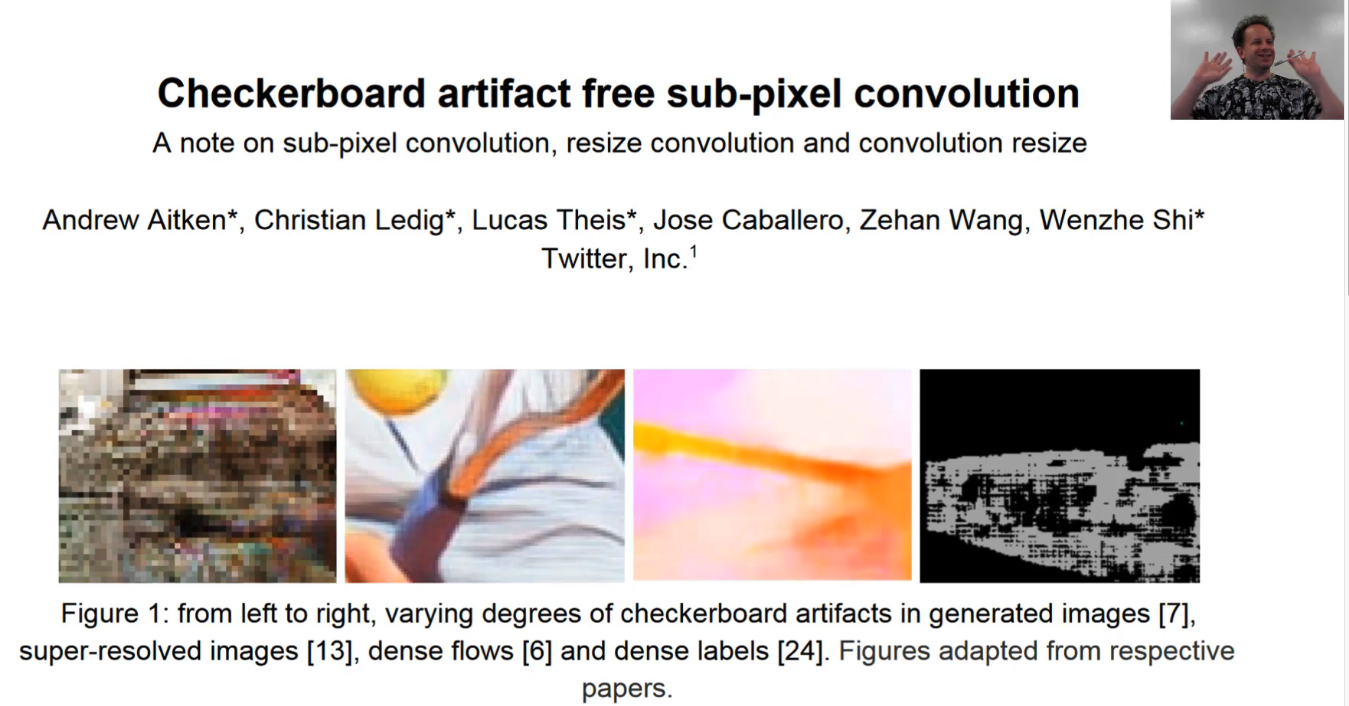

Why do we still have a checkerboard? 
Because when we randomly initialize this convolutional kernel at the start, 
it means that each of the (output) 9 pixels in a 3x3 grid are going to be randomly different. 
But then the next set of 3 pixels will be randomly different to each other, but will be very similar to their corresponding pixel in the previous 3x3 section. 
So we are going to have repeating 3x3 "patterns" all the way. 
Then as we try to learn something better, it’s starting from a 
repeating 3x3 starting point which is not what we want. 
We want the (output) 3x3 pixels to be the same to start with. 
To make these (output) 3x3 pixels the same, we need to make the 9 channels $[1,1]$ the same for each filter. 
So the solution in this paper is, when we initialize this convolution at start,
we **don’t** randomly initialize it. 
Instead, we randomly initialize one of the r² sets of channels,
then we copy that to the other r² so they are all the same. 
That way, initially, each of these 3x3 will be the same. 
So that is called ICNR and that’s what we are going to use in a moment.

### Pixel loss 
[46:41]
Before we do, let’s take a quick look. 
So we’ve got this super resolution ResNet which just does lots of computation with lots of ResNet blocks and then it does some upsampling and gets our final three channels out.
Then to make life faster, we are going to run tins in parallel. 

## Progressive resizing
Starting small and gradually making bigger.
We’ve done it for scale equals 2 — progressive resizing. 
Progressive resizing let us get the best best single computer result for ImageNet training on DAWN bench. 
Other papers that used progressive resizing are a GANs paper, which allows training 
a very high resolution GANs, and the EDSR paper. 
Progressive resizing is faster. 
We can also make the batch size maybe 3 or 4 times bigger. 
But more importantly, they are going to generalize better, because we are feeding the model different sized images during training. 
So we were able to train half as many epochs for ImageNet as most people. 
Our epochs were faster and there were fewer of them. 
So progressive resizing is something that, particularly if you are training from scratch (I’m not so sure if it’s useful for fine-tuning transfer learning, but if you are training from scratch), you probably want to do nearly all the time.

But there’s a slight issue which is I now have one more upsampling layer than I used to have to go from 2x2 to 4x4. My loop here is now looping through twice, not once. Therefore, it’s added an extra conv net and an extra pixel shuffle. So how am I going to load in weights for a different network?

We use PyTorch `load_state_dict`. 
This is what `lean.load` calls behind the scenes. 
If we pass `strict=False` then it says “okay, if you can’t fill in all of the layers, just fill in the layers you can.” 
So after loading the model back in this way, 
we are going to end up with something where it’s loaded in all the layers that it can, 
and that one conv layer that’s new is going to be randomly initialized.

Then we freeze all my layers and then unfreeze that upsampling part [1:00:45](https://youtu.be/nG3tT31nPmQ?t=1h45s) 
Then use `icnr` on my newly added extra layer. 
Then we can go ahead and learn again, and then the rest is the same.

**When trying to replicate this, don’t just run this top to bottom. It involves a bit of jumping around.**

# Segmentation
This is from the famous CamVid dataset which is a classic example of an academic segmentation dataset. Basically you can see what we do is we start with a picture (they are actually video frames in this dataset) and we have some labels where they are not actually colors — each one has an ID and the IDs are mapped to colors. So red might be 1, purple might be 2, light pink might be 3 and so all the buildings are one class, all the cars are another class, all the people are another class, all the road is another class, and so on. So what we are actually doing here is multi-class classification for every pixel. You can see, sometimes that multi-class classification really is quite tricky — like these branches. Although, sometimes the labels are really not that great. This is very coarse as you can see. So that’s what we are going to do.

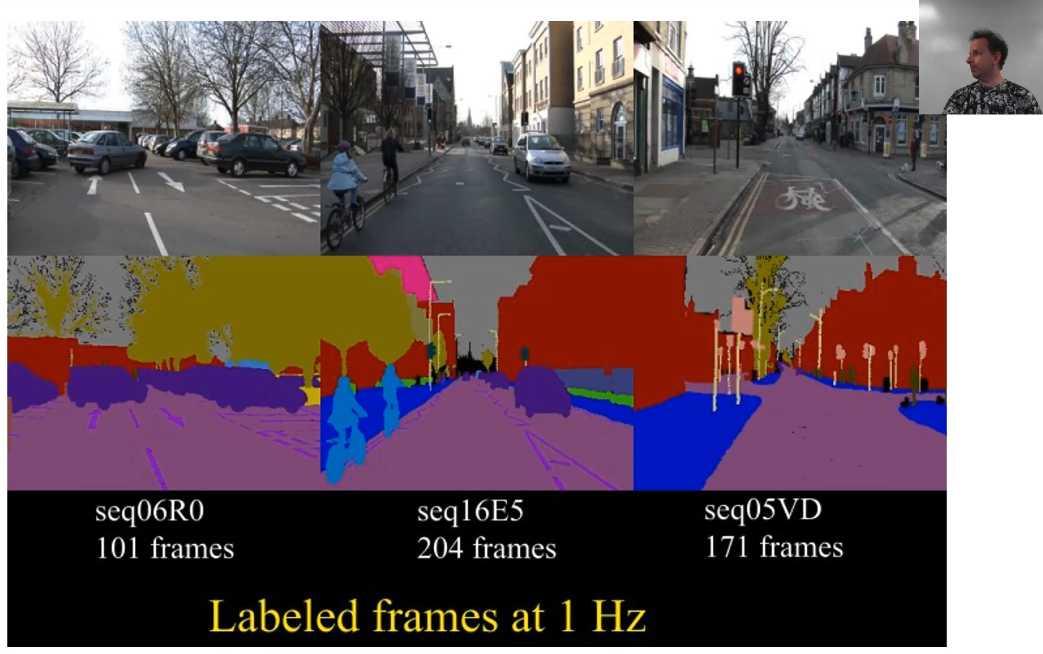

We are going to do segmentation and so it’s a lot like bounding boxes. 
But rather than just finding a box around each thing, we are actually going to label every single pixel with its class. 
It is easier because it fits our CNN style so nicely that we can create any CNN where the output is an NxM grid containing the integers from 0 to C where there are C categories. 
And then we can use cross-entropy loss with a softmax activation and we are done. 
We can use the same approaches we learnt in early lessons and we get a good result. 
This is not hard, so we are going to do it really well.

# U-net

- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

U-Net network is quite magnificent. 
With that previous approach, our pre-trained ImageNet network was being squished down all the way down to 7x7 and then expand it out all the way back up to 224x224 (1024 gets squished down to quite a bit bigger than 7x7). 
And then expanded out again all this way which means it has to somehow store all the information about the much bigger version in the small version. 
And actually most of the information about the bigger version was really in the original picture anyway. 
So it doesn’t seem like a great approach — this squishing and un-squishing.

The U-Net idea comes from the above paper.
It was invented for a domain-specific area of biomedical image segmentation. 
But now, most Kaggle winners in anything vaguely related to segmentation are using U-Net. 
All in Kaggle know it is the best practice, but in academic circles, 
many still don’t realize this is by far the best approach.

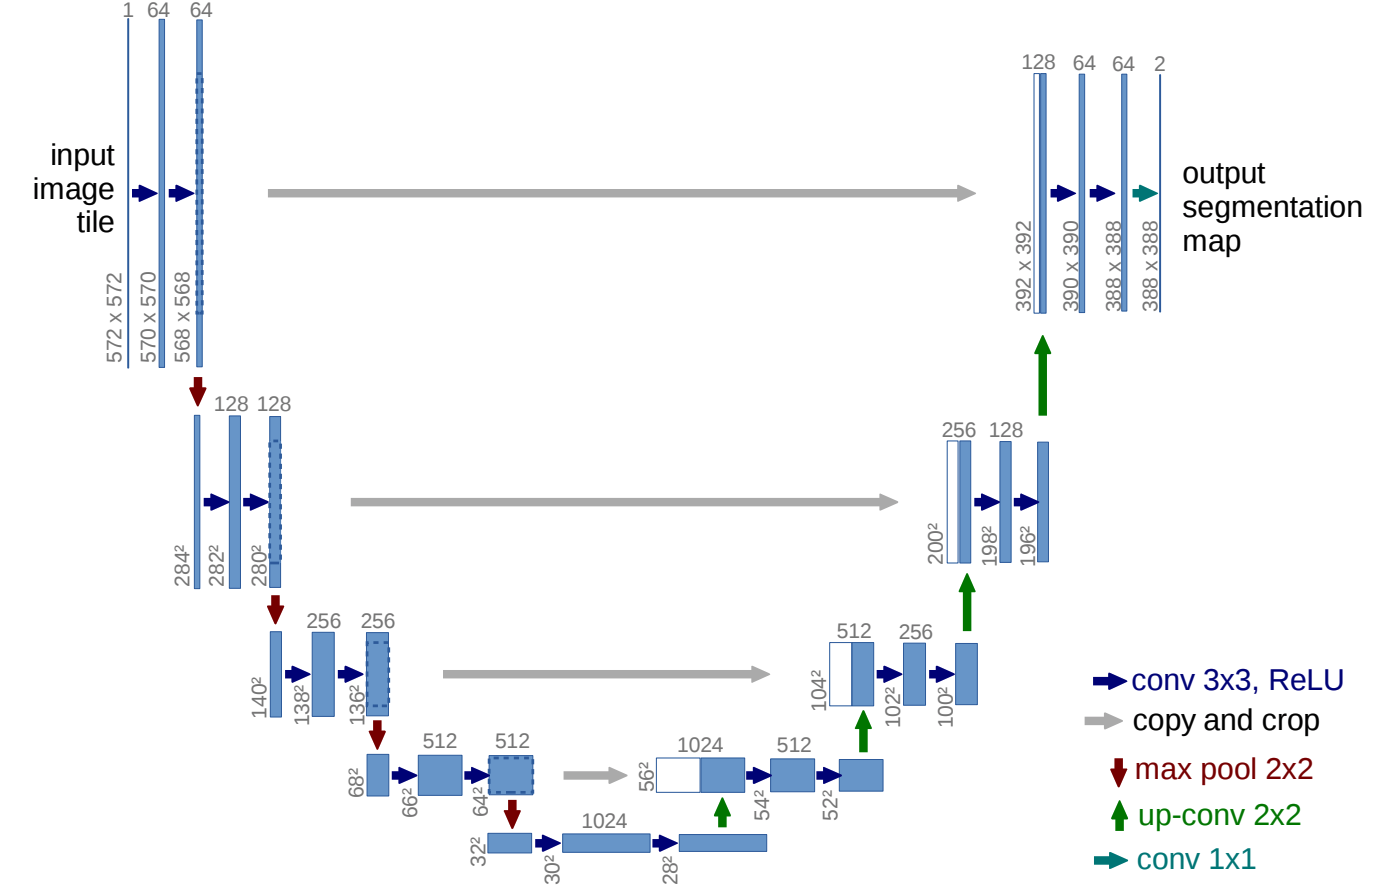

Here is the basic idea [1:45:10](https://youtu.be/nG3tT31nPmQ?t=1h45m10s). 
On the left is the downward path where we start at 572x572 in this case then halve the grid size 4 times, 
then on the right is the upward path where we double the grid size 4 times. 
But at every point where we halve the grid size, we copy those activations to the upward path and concatenate them together.

You can see on the bottom right, these red arrows are max pooling operation, these green arrows are upward sampling, and then these gray arrows are copying. 
So we copy and concat. 
In other words, the input image after a couple of convs is copied over to the output, 
concatenated together.
So we get to use all of the information gone through all the down and all the up, 
plus also a slightly modified version of the input pixels. 
And slightly modified version of one thing down from the input pixels because they came up through here. 
So we have all of the richness of going all the way down and up, but also a slightly less coarse version and a slightly less coarse version and then the really simple version, and they can all be combined together. 
So that’s U-Net.